# Benchmarking InceptionTime on Smartwatch Gestures Dataset
FordA dataset from the UCR/UEA archive.
The following notebook tests the speed at which a given device can perform training iterations on the [FordA dataset](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/) (2 classes, 4,821 training sequences, 1 channel) training the InceptionTime architecture.

The test is designed to compare the M1 Max 24 Core 32 GB RAM GPU with the Colab Pro P100 GPU.

| Model | Dataset | Train Size | Sequence Length |
| ----- | ----- | ----- | ----- |
| [InceptionTime](https://github.com/hfawaz/InceptionTime) (trained from scratch) | Smartwatch Gestures (from TensorFlow Datasets) | ~4,800  images | 500 |

## Resources
* Code on GitHub: https://github.com/JanMarcelKezmann/colab_pro_vs_m1_max

# Check for GPU

In [ ]:
!nvidia-smi

Thu Feb 17 16:20:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
!pip install -q tfds-nightly

     |████████████████████████████████| 4.2 MB 7.3 MB/s 


In [ ]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output

# Global Variables

In [ ]:
N_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
LR_PATIENCE = 15
NB_FILTERS = 32
USE_RESIDUAL = True
USE_BOTTLENECK = True
BOTTLENECK_SIZE = 32
DEPTH = 10
KERNEL_SIZE = 40
MONITOR = "val_loss"

# Download the FordA dataset & Perform Preprocessing

### Load the Data

Credit goes to [hfawaz](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/) for data loading functions.

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

X_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
X_test, y_test = readucr(root_url + "FordA_TEST.tsv")

### Visualize the Data

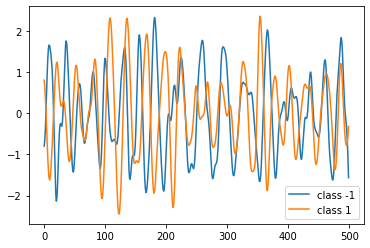

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_X_train = X_train[y_train == c]
    plt.plot(c_X_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


### Standardize the Data

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Build the Model

In [ ]:
class InceptionTimeClassifier:
    def __init__(self, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, bottleneck_size=32, depth=6,
                 kernel_size=40, nb_epochs=1500, callbacks=None):

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size
        self.callbacks = callbacks
        self.batch_size = batch_size
        self.bottleneck_size = bottleneck_size
        self.nb_epochs = nb_epochs
        
        self.loss = 'sparse_categorical_crossentropy' # default: 'categorical_crossentropy'

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = tf.keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = tf.keras.layers.Concatenate(axis=2)(conv_list)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation='relu')(x)
        
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        x = tf.keras.layers.Add()([shortcut_y, out_tensor])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = tf.keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)
        output_layer = tf.keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=self.loss, optimizer=tf.keras.optimizers.Adam(), metrics=['sparse_categorical_accuracy']) # ['accuracy', MulticlassAUC()])

        return model

    def fit(self, x_train, y_train, class_weight=None, validation_data=None):
        hist = self.model.fit(
            x_train,
            y_train,
            batch_size=self.batch_size,
            epochs=self.nb_epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            class_weight=class_weight,
            validation_data=validation_data
        )

        return hist

    def predict(self, X_test):
        return self.model.predict(X_test, batch_size=self.batch_size, verbose=1)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor=MONITOR,
        factor=0.5,
        patience=LR_PATIENCE,
        min_lr=LEARNING_RATE
    )
]
    
# Initialize and Compile Model
model = InceptionTimeClassifier(
    input_shape=X_train.shape[1:],
    nb_classes=N_CLASSES,
    verbose=True,
    build=True,
    batch_size=BATCH_SIZE,
    nb_filters=NB_FILTERS,
    use_residual=USE_RESIDUAL,
    use_bottleneck=USE_BOTTLENECK,
    bottleneck_size=BOTTLENECK_SIZE,
    depth=DEPTH,
    kernel_size=KERNEL_SIZE,
    nb_epochs=EPOCHS,
    callbacks=callbacks
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 500, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 32)      1280        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 32)      640         ['input_1[0][0]']                
                                                                                              

# Train the Model

In [ ]:
start_time = time()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
)
print(f"Model training took {time() - start_time} seconds.")

Epoch 1/20
113/113 [==============================] - 24s 70ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.3640 - val_sparse_categorical_accuracy: 0.8530 - lr: 0.0010
Epoch 2/20
113/113 [==============================] - 7s 60ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.9320 - val_loss: 0.1925 - val_sparse_categorical_accuracy: 0.9333 - lr: 0.0010
Epoch 3/20
113/113 [==============================] - 7s 60ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.2967 - val_sparse_categorical_accuracy: 0.9030 - lr: 0.0010
Epoch 4/20
113/113 [==============================] - 7s 60ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.8848 - lr: 0.0010
Epoch 5/20
113/113 [==============================] - 7s 60ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9428 - val_loss: 1.1977 - val_sparse_categorical_accuracy: 0.6470 - lr: 0.0010
Epoch 6/20
113/113 [=========

# Computing Inference Time on all examples

In [ ]:
%%timeit
y = model.predict(X_test)

42/42 [==============================] - 1s 15ms/step
1 loop, best of 5: 705 ms per loop


In [3]:
574 / 770

0.7454545454545455